# EEG Emotion Classifier

Questo notebook esegue la classificazione delle emozioni a partire da segnali EEG. In particolare:

- Carica e prepara il dataset separando le feature EEG dalla colonna target (emozione).
- Codifica le etichette delle emozioni in valori numerici e le converte in one-hot encoding.
- Divide il dataset in training e test set, standardizzando le feature EEG.
- Definisce e compila un modello di rete neurale feedforward con due layer densi e dropout per prevenire l'overfitting.
- Allena il modello utilizzando una callback di early stopping basata sulla validazione per evitare overfitting.
- Valuta le prestazioni sul test set.
- Salva il modello addestrato e lo scaler utilizzato per la standardizzazione.


## 0: Setup Iniziale e Importazione Librerie


In [1]:
# Installazione delle librerie

!pip install -q pandas numpy scikit-learn tensorflow Pillow scikit-fuzzy matplotlib seaborn
print("Librerie installate con successo!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 8.9 MB/s eta 0:00:00
Librerie installate con successo!


In [2]:
# Accesso a Google Drive
from google.colab import drive

# Analisi e manipolazione dei dati
import pandas as pd
import numpy as np
import os

# Visualizzazione dei dati
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing e modellazione con Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib

# Costruzione, addestramento e salvataggio di modelli con TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Logica fuzzy con SciKit-Fuzzy
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Manipolazione di immagini
from PIL import Image, ImageDraw

# Operazioni casuali
import random


## 1: Collegemanto a Google Drive e Importazione File Necessari


In [3]:
# Monta Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Percorso al file nel Drive
file_path = '/content/drive/MyDrive/Colab Notebooks/IA FROM ENGINEERING TO ARTS/ADDESTRAMENTO/eeg_brainwave_dataset.csv'

# Caricamento del dataset
df = pd.read_csv(file_path)
print("Dataset caricato con successo.")
print(df.head())

Dataset caricato con successo.
   # mean_0_a  mean_1_a  mean_2_a  mean_3_a  mean_4_a  mean_d_0_a  mean_d_1_a  \
0        4.62      30.3    -356.0      15.6      26.3       1.070       0.411   
1       28.80      33.1      32.0      25.8      22.8       6.550       1.680   
2        8.90      29.4    -416.0      16.7      23.7      79.900       3.360   
3       14.90      31.6    -143.0      19.8      24.3      -0.584      -0.284   
4       28.30      31.3      45.2      27.3      24.5      34.800      -5.790   

   mean_d_2_a  mean_d_3_a  mean_d_4_a  ...  fft_741_b  fft_742_b  fft_743_b  \
0      -15.70        2.06        3.15  ...       23.5       20.3       20.3   
1        2.88        3.83       -4.82  ...      -23.3      -21.8      -21.8   
2       90.20       89.90        2.03  ...      462.0     -233.0     -233.0   
3        8.82        2.30       -1.97  ...      299.0     -243.0     -243.0   
4        3.06       41.40        5.52  ...       12.0       38.1       38.1   

   fft_

## 2: Inizializzazione e Setup dell'Ambiente


In [5]:
# Colonna target (emozione)
emotion_col = 'label'

# Colonne EEG (tutte tranne la colonna target)
eeg_cols = [col for col in df.columns if col != emotion_col]

# Separazione delle feature e delle etichette
X = df[eeg_cols].values
y = df[emotion_col].values

print(f"\nColonna target: {emotion_col}")
print(f"\nNumero di feature EEG: {len(eeg_cols)}")
print(f"\nDimensione matrice feature X: {X.shape}")
print(f"\nDimensione vettore etichette y: {y.shape}")


Colonna target: label

Numero di feature EEG: 2548

Dimensione matrice feature X: (2132, 2548)

Dimensione vettore etichette y: (2132,)


## 3: Preparazione del Dataset e Pre-Elaborazione dei Dati



Classi di emozione rilevate: ['NEGATIVE' 'NEUTRAL' 'POSITIVE']


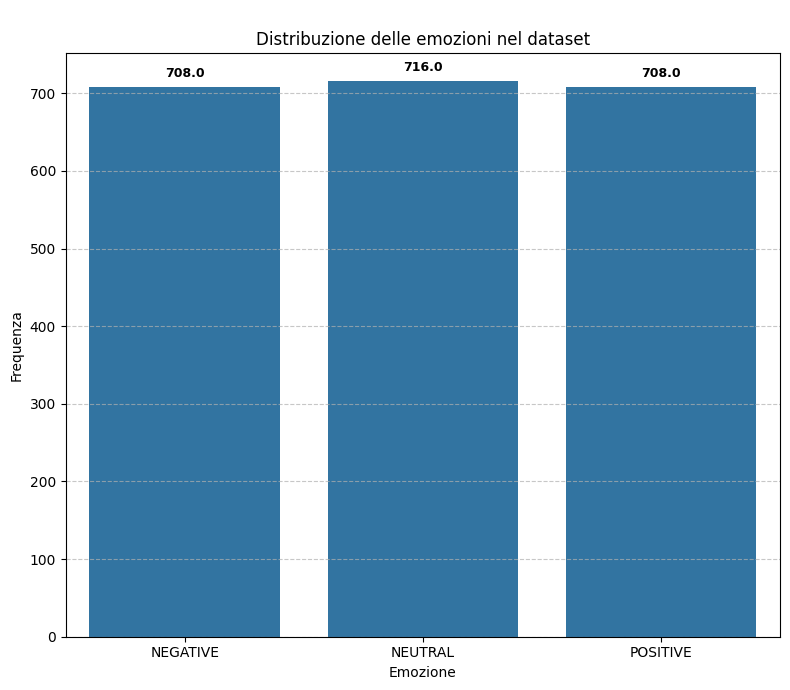


Dataset diviso in training e test set.

Feature EEG standardizzate.

Etichette codificate in one-hot encoding.

Scaler salvato con successo.


In [6]:
# Codifica delle etichette in interi
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)
print(f"\nClassi di emozione rilevate: {label_encoder.classes_}")

# Distribuzione delle Emozioni
plt.figure(figsize=(8, 7))
ax = sns.countplot(x=y)
plt.title('\nDistribuzione delle emozioni nel dataset')
plt.xlabel('Emozione')
plt.ylabel('Frequenza')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Aggiunta delle etichette di frequenza sopra ogni barra
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', xy=(p.get_x() + p.get_width() / 2, height),
                xytext=(0, 5), textcoords='offset points',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Divisione in training e test set
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Standardizzazione delle feature EEG
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Salvataggio dello scaler
joblib.dump(scaler, '/content/drive/MyDrive/Colab Notebooks/IA FROM ENGINEERING TO ARTS/INFERENZA/FILE DI SUPPORTO/scaler.pkl')

# Conversione delle etichette in one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

print("\nDataset diviso in training e test set.")
print("\nFeature EEG standardizzate.")
print("\nEtichette codificate in one-hot encoding.")
print("\nScaler salvato con successo.")


## 4. Creazione del Modello di Classificazione Emotiva (Rete Neurale)
Definizione, addestramento e valutazione di un modello di rete neurale artificiale per la classificazione delle emozioni basata su Segnali EEG preprocessati . La rete è una MLP (Multi-Layer Perceptron) con due layer densi (Dense) e dropout per ridurre l’overfitting. Viene utilizzata la funzione di attivazione ReLU e una softmax finale per classificare in più classi.

Il modello è compilato con l’ottimizzatore Adam e la loss categoriale per problemi di classificazione multi-classe. Per evitare overfitting, viene applicato un callback di early stopping monitorando la validazione.

L’addestramento avviene con un’early stopping su un validation split del 20%. Al termine, il modello viene valutato sul test set e salvato.


In [7]:
# Definizione del modello di rete neurale
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compilazione del modello
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Riepilogo della rete
model.summary()

# Definizione callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Addestramento del modello con early stopping
history = model.fit(
    X_train_scaled, y_train_one_hot,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Valutazione sul test set
loss, accuracy = model.evaluate(X_test_scaled, y_test_one_hot, verbose=0)
print(f"\nLoss sul test set: {loss:.4f}")
print(f"Accuratezza sul test set: {accuracy * 100:.2f}%")

# Salvataggio del modello addestrato
model.save('/content/drive/MyDrive/Colab Notebooks/IA FROM ENGINEERING TO ARTS/INFERENZA/FILE DI SUPPORTO/emotion_classifier_model.keras')
print("\nModello salvato come 'emotion_classifier_model.keras'.")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       326,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 334,723 (1.28 MB)

 Trainable params: 334,723 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6729 - loss: 1.0050 - val_accuracy: 0.9413 - val_loss: 0.2297
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8919 - loss: 0.3608 - val_accuracy: 0.9326 - val_loss: 0.1883
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8818 - loss: 0.3016 - val_accuracy: 0.9472 - val_loss: 0.1592
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9186 - loss: 0.2139 - val_accuracy: 0.9443 - val_loss: 0.1290
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9198 - loss: 0.1989 - val_accuracy: 0.9472 - val_loss: 0.1230
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9448 - loss: 0.1555 - val_accuracy: 0.9648 - val_loss: 0.1046
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9495 - loss: 0.1696 - val_accuracy: 0.9619 - val_loss: 0.1030
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9575 - loss: 0.1071 - val_accuracy: 0.9765 - val_lo

## 4. Visualizzazione delle Metriche


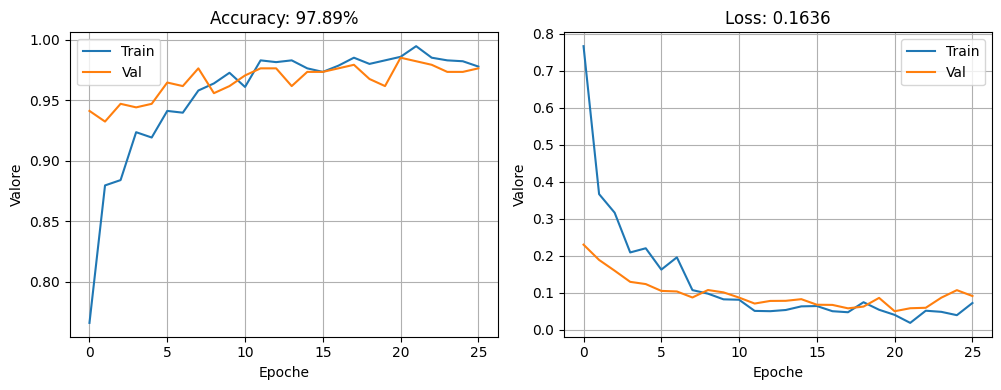

In [8]:
# Imposta dimensioni del canvas
plt.figure(figsize=(20, 4))

# -------- Accuracy --------
plt.subplot(1, 4, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title(f'Accuracy: {accuracy * 100:.2f}%')
plt.xlabel('Epoche')
plt.ylabel('Valore')
plt.legend()
plt.grid(True)

# -------- Loss --------
plt.subplot(1, 4, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title(f'Loss: {loss:.4f}')
plt.xlabel('Epoche')
plt.ylabel('Valore')
plt.legend()
plt.grid(True)


# Mostra tutti i grafici
plt.tight_layout()
plt.show()